In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# from scipy.optimize import differential_evolution
# import multiprocessing
# multiprocessing.set_start_method("spawn", force=True)

from repeated.IBL_v2 import IBLAgent
from repeated.IBLPT_v1 import PTIBLAgent
from repeated.human_metrc import *

cols = ['id','val_high','p_high','val_low','val_safe','sure','d1','mode']
est  = pd.read_csv('repeated/data/60estimationset.dat',   sep=r'\s+', header=None, names=cols)
comp = pd.read_csv('repeated/data/60competitionset.dat', sep=r'\s+', header=None, names=cols)

def eval_ts(dataset, human_ts, params, use_pt=False, N=100, agents=5):
    P = len(dataset)
    r_acc = np.zeros(N)
    a_acc = np.zeros(N)
    for _, row in tqdm(dataset.iterrows(),total=dataset.shape[0]):
        R = np.zeros((agents, N))
        A = np.zeros((agents, N))
        for ai in range(agents):
            agent = PTIBLAgent(*params) if use_pt else IBLAgent(*params)
            seq   = agent.run_n(row, N)
            R[ai] = [int(c == 'risky') for c in seq]
            A[ai,0] = 0
            for t in range(1, N):
                A[ai,t] = int(seq[t] != seq[t-1])
        r_acc += R.mean(axis=0)
        a_acc += A.mean(axis=0)
    return r_acc / P, a_acc / P

def MSD(x, y):
    return np.mean((x - y)**2)

def summarize(label, params, use_pt,agents=5):
    # Estimation
    r_est, a_est = eval_ts(est, human_r_ts_est, params, use_pt, N=100, agents=agents)
    # Competition
    r_cmp, a_cmp = eval_ts(comp, human_r_ts_comp, params, use_pt, N=100, agents=agents)

    # compute metrics
    def metrics(model_ts, human_ts, k):
        msd = MSD(model_ts, human_ts)
        corr = np.corrcoef(model_ts, human_ts)[0,1]
        aic = 100 * np.log(max(msd,1e-8)) + 2*k
        return msd, corr, aic

    k = 3 + (3 if use_pt else 0)
    msd_re, cr_re, aic_re = metrics(r_est, human_r_ts_est,   k)
    msd_ae, cr_ae, aic_ae = metrics(a_est, human_a_ts_est,   k)
    msd_rc, cr_rc, aic_rc = metrics(r_cmp, human_r_ts_comp,  k)
    msd_ac, cr_ac, aic_ac = metrics(a_cmp, human_a_ts_comp,  k)

    print(f"\n{label}:")
    print(f"  Est R → MSD={msd_re:.4f}, Corr={cr_re:.3f}, AIC={aic_re:.1f}")
    print(f"  Est A → MSD={msd_ae:.4f}, Corr={cr_ae:.3f}, AIC={aic_ae:.1f}")
    print(f"  Cmp R → MSD={msd_rc:.4f}, Corr={cr_rc:.3f}, AIC={aic_rc:.1f}")
    print(f"  Cmp A → MSD={msd_ac:.4f}, Corr={cr_ac:.3f}, AIC={aic_ac:.1f}")

    scores={'comp_a_msd':msd_ac,
            'comp_a_aic':aic_ac,
            'comp_r_msd':msd_rc,
            'comp_r_aic':aic_rc,
            'est_a_msd':msd_ae,
            'est_a_aic':aic_ae,
            'est_r_msd':msd_re,
            'est_r_aic':aic_re
            }
    return a_cmp,a_est,r_cmp,r_est,scores



In [3]:
# pt_opt=[4.14310027,2.90390442,0.31672608,0.28091575,0.92118201,4.74019194]
# pt_opt=[5.10216799,0.84474049,0.33049826,0.661184,0.83825848,4.05573251]
pt_opt=[5.23687256,0.80572283,0.29879144,0.27576091,0.43399108,4.01762585]
a_cmp,a_est,r_cmp,r_est,scores=summarize("ibl-pt opt r-rate 85%", pt_opt, True,agents=15)

100%|██████████| 60/60 [01:01<00:00,  1.02s/it]


ibl-pt opt r-rate 85%:
  Est R → MSD=0.0008, Corr=0.841, AIC=-701.8
  Est A → MSD=0.0008, Corr=0.963, AIC=-697.1
  Cmp R → MSD=0.0038, Corr=0.864, AIC=-545.9
  Cmp A → MSD=0.0005, Corr=0.974, AIC=-739.9


In [4]:
def save_results(path,res,scores,pt_opt):

    path_runs_record=os.path.join(path,'repeated_runs.xlsx')

    # check directories crete if missing    
    if not os.path.exists(path):
        os.makedirs(path)    
    mode=True

    # check meta sheet
    if os.path.exists(path_runs_record):
        try:
            df_meta=pd.read_excel(path_runs_record,sheet_name='runs_record',engine='openpyxl')
            max_run = max(df_meta['run'].unique())
            current_run = max_run+1
            xls = pd.ExcelFile(path_runs_record)
            sheets = xls.sheet_names

        except ValueError:
            sheets=[]
            mode=False 
    else:
        mode=False

    # create if not exists
    if not mode:
        current_run=1
        df_meta=pd.DataFrame()
            
    print('Current run:',current_run)  

    new_record={'run':current_run,'params':pt_opt}
    for  k,v in scores.items():
        new_record[k]=v
    df_new_record=pd.DataFrame([new_record])

    # merge all 
    df_meta = pd.concat([df_meta,df_new_record])
    
    # load existing records 
    dfs={}
    if mode: 
        for s in sheets:
            if not s == 'runs_record':
                dfs[s]=pd.read_excel(path_runs_record,sheet_name=s,engine='openpyxl')
        
    # create current sheet 
    df_run = pd.DataFrame({'a_cmp':res[0],'a_est':res[1],'r_cmp':res[2],'r_est':res[3]})

    # save all results
    writer = pd.ExcelWriter(path_runs_record, engine='openpyxl')
    print('Updated meta sheet')
    df_meta.to_excel(writer,sheet_name='runs_record', index=False)

    print('Added run sheet')
    for sheet_name,sheet_df in dfs.items():
        sheet_df.to_excel(writer,sheet_name=sheet_name, index=False)
    sheet_name = f'run_{current_run}'
    df_run.to_excel(writer,sheet_name=sheet_name, index=False)
    writer.close()


temp_path='logs\\repeated_model_results'
save_results(temp_path,(a_cmp,a_est,r_cmp,r_est),scores,pt_opt)

Current run: 6
Updated meta sheet
Added run sheet


In [2]:
file_path='D:\\Workspace\\tpt_models\\repeated\\data\\model_ibl_ararte.csv'
df=pd.read_csv(file_path)
ibl_arate_comp=df.arate_comp.values
ibl_arate_est=df.arate_est.values
ibl_rrate_est=df.rrate_est.values
ibl_rrate_comp=df.rrate_comp.values


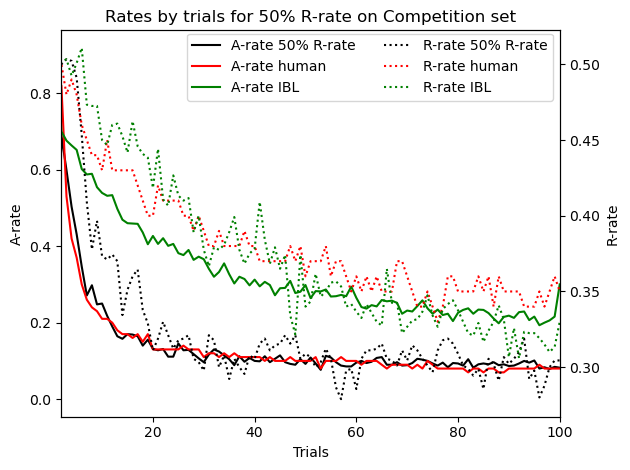

In [27]:
def plot_twin(a_rate_model, a_rate_human, a_rate_pysch,
              r_rate_model, r_rate_human, r_rate_pysch,
              model_name='default', set_="estimation"):

    trials = np.arange(1, 101)
    fig, ax1 = plt.subplots()

    # Left Y-axis plots
    line1, = ax1.plot(trials, a_rate_model, linestyle='-', color='black', label=f'A-rate {model_name}')
    line2, = ax1.plot(trials, a_rate_human, linestyle='-', color='red', label='A-rate human')
    line3, = ax1.plot(trials, a_rate_pysch, linestyle='-', color='green', label='A-rate IBL')
    ax1.set_xlabel('Trials')
    ax1.set_ylabel('A-rate')
    ax1.tick_params(axis='y')
    ax1.set_xlim(1, 100)

    # Right Y-axis plots
    ax2 = ax1.twinx()
    line4, = ax2.plot(trials, r_rate_model, linestyle=':', color='black', label=f'R-rate {model_name}')
    line5, = ax2.plot(trials, r_rate_human, linestyle=':', color='red', label='R-rate human')
    line6, = ax2.plot(trials, r_rate_pysch, linestyle=':', color='green', label='R-rate IBL')
    ax2.set_ylabel('R-rate')
    ax2.tick_params(axis='y')
    ax1.set_xlim(2, 100)

    # Combine all lines for a single unified legend
    lines = [line1, line2, line3, line4, line5, line6]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='lower right', bbox_to_anchor=(1, 0.8), ncol=2)

    plt.title(f'Rates by trials for {model_name} on {set_} set')
    plt.tight_layout()
    plt.show()


path='logs\\repeated_model_results'
path_runs_record=os.path.join(path,'repeated_runs.xlsx')
df_15=pd.read_excel(path_runs_record,sheet_name=f'run_6',engine='openpyxl')
# ['a_cmp','a_est','r_cmp','r_est']
# a_rate_model=df_15['a_est']
# r_rate_model=df_15['r_est']
# human_a = human_a_ts_est
# human_r=human_r_ts_est
# ibl_a = ibl_arate_est
# ibl_r=ibl_rrate_est
# set_ ='Estimation'

a_rate_model=df_15['a_cmp']
r_rate_model=df_15['r_cmp']
human_a = human_a_ts_comp
human_r=human_r_ts_comp
ibl_a = ibl_arate_comp
ibl_r=ibl_rrate_comp
set_ ='Competition'

plot_twin(a_rate_model,human_a,ibl_a,r_rate_model,human_r,ibl_rrate_est,model_name='50% R-rate',set_=set_)


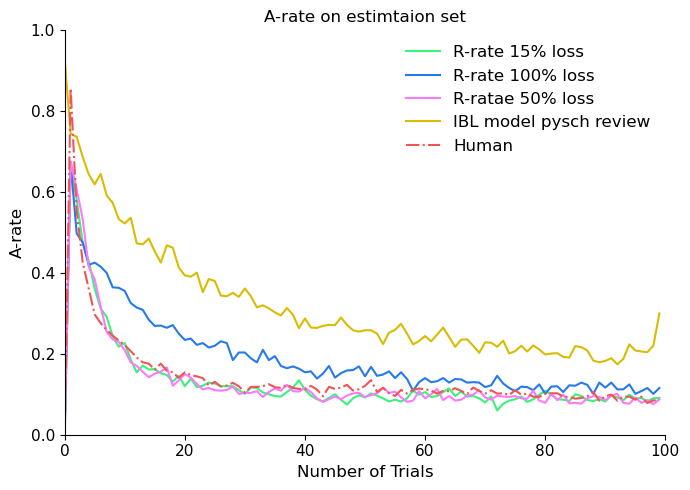

In [8]:
def plot_combined(runA,runB,runC,human_scores,run_names=['runA','runB','runC'],title='Title',metric='a_cmp',include_pysch=False):
    if include_pysch:
        if metric in ['a_cmp','a_est','r_cmp','r_est']:
            file_path='D:\\Workspace\\tpt_models\\repeated\\data\\model_ibl_ararte.csv'
            df=pd.read_csv(file_path)
            ibl_arate_comp=df.arate_comp.values
            ibl_arate_est=df.arate_est.values
            ibl_rrate_est=df.rrate_est.values
            ibl_rrate_comp=df.rrate_comp.values

            # assign the right one	
            if metric=='a_cmp':
                ibl_score = ibl_arate_comp
            elif metric=='a_est':
                ibl_score = ibl_arate_est
            elif metric=='r_cmp':
                ibl_score = ibl_rrate_comp
            elif metric == 'r_est':
                ibl_score = ibl_rrate_est
        else:
            print("+Invalid metric+")
            include_pysch=False

    # Create trial range
    trials = np.arange(0, 100)

    # Approximate curves
    human_curve = np.exp(-0.08 * (trials - 2)) * 0.9 + 0.05
    ibl_curve = np.exp(-0.04 * (trials - 2)) * 0.9 + 0.15

    # Plot
    fig, ax = plt.subplots(figsize=(7,5))


    # Plot the lines
    ax.plot(trials, runA, color='#38f279', label=run_names[0])
    ax.plot(trials, runB, color='#2679ed', label=run_names[1])
    if runC is not None:
        ax.plot(trials, runC, color='#ff79ff', label=run_names[2])
    if include_pysch:
        ax.plot(trials, ibl_score, color='#d9bc02', label='IBL model pysch review')
    ax.plot(trials, human_scores, color='#f05454', linestyle='-.', label='Human')

    ax.set_title(title)

    # Axis limits and labels
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Number of Trials', fontsize=12)
    if metric in ['a_cmp','a_est']:
        ylabel="A-rate"
    else:
        ylabel="R-rate"
    ax.set_ylabel(ylabel, fontsize=12)

    ax.legend(frameon=False, fontsize=12, loc='upper right')
    sns.despine()
    ax.grid(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.tick_params(axis='both', which='major', labelsize=11)
    plt.tight_layout()
    plt.show()


#load data 
path='logs\\repeated_model_results'
path_runs_record=os.path.join(path,'repeated_runs.xlsx')
# a_cmp	a_est	r_cmp	r_est
metric='a_est'

def get_data(sheet_run_a=1,sheet_run_b=2,path_runs_record='',metric='a_cmp'):
    df_A=pd.read_excel(path_runs_record,sheet_name=f'run_{sheet_run_a}',engine='openpyxl')
    df_B=pd.read_excel(path_runs_record,sheet_name=f'run_{sheet_run_b}',engine='openpyxl')

    return df_A[metric].values,df_B[metric].values


if metric=='a_cmp':
    human_record = human_a_ts_comp
    title='A-rate on competition set'
elif metric=='a_est':
    human_record = human_a_ts_est
    title='A-rate on estimtaion set'

elif metric=='r_cmp':
    human_record = human_r_ts_comp
    title='R-rate on competition set'
elif metric == 'r_est':
    human_record = human_r_ts_est
    title='R-rate on estimtaion set'

runA,runB=get_data(sheet_run_a=4,sheet_run_b=5,path_runs_record=path_runs_record,metric=metric)
runA,runC=get_data(sheet_run_a=4,sheet_run_b=6,path_runs_record=path_runs_record,metric=metric)
plot_combined(runA,runB,runC,human_record,run_names=['R-rate 15% loss','R-rate 100% loss','R-ratae 50% loss'],title=title,metric=metric,include_pysch=True)


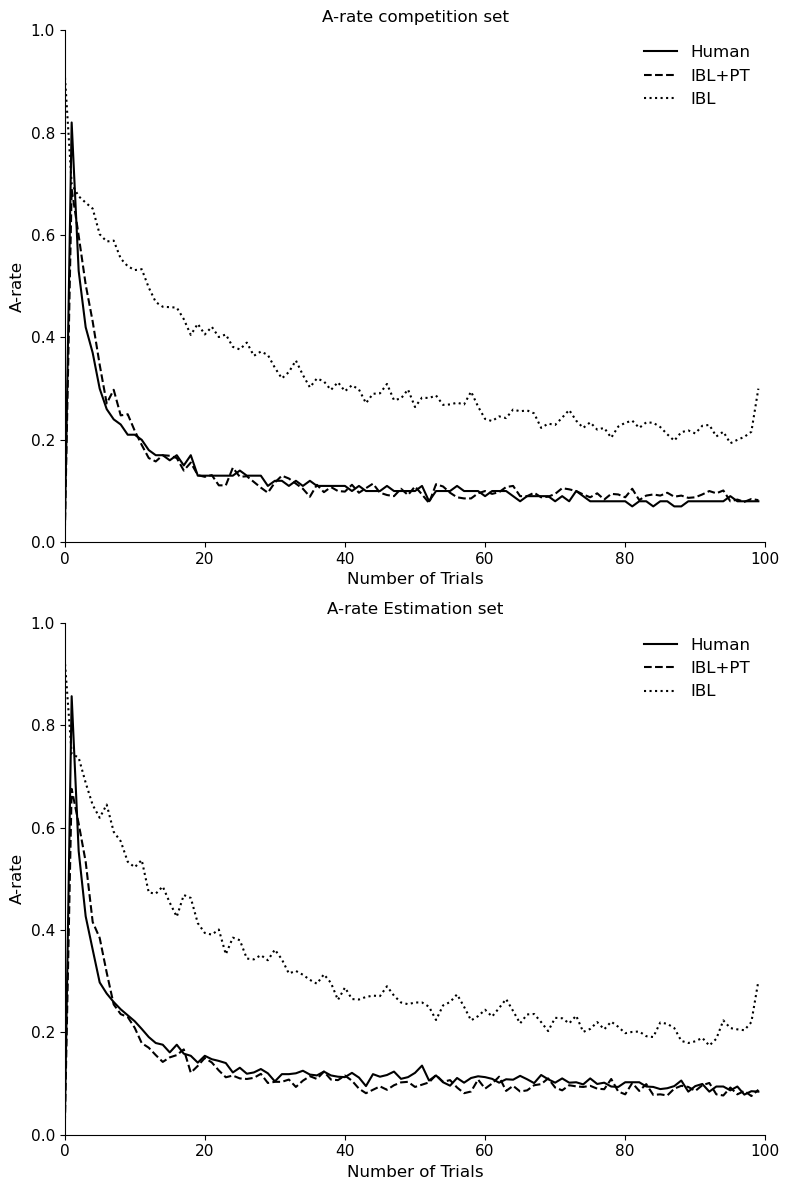

In [ ]:


# Create trial range
trials = np.arange(1, 101)


# Plot
fig, ax = plt.subplots(2,1,figsize=(8, 12))

# Plot the lines
ax[0].plot(trials, human_a_ts_comp, color='black', linestyle='-', label='Human')
ax[0].plot(trials, a_cmp, color='black', linestyle='--', label='IBL+PT')
ax[0].plot(trials, ibl_arate_comp, color='black', linestyle=':', label='IBL')
ax[0].set_title('A-rate competition set')

ax[1].plot(trials, human_a_ts_est, color='black', linestyle='-', label='Human')
ax[1].plot(trials, a_est, color='black', linestyle='--', label='IBL+PT')
ax[1].plot(trials, ibl_arate_est, color='black', linestyle=':', label='IBL')
ax[1].set_title('A-rate Estimation set')


# Axis limits and labels
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Number of Trials', fontsize=12)
ax[0].set_ylabel('A-rate', fontsize=12)

ax[1].set_xlim(0, 100)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Number of Trials', fontsize=12)
ax[1].set_ylabel('A-rate', fontsize=12)

# Legend without frame
ax[0].legend(frameon=False, fontsize=12, loc='upper right')
ax[1].legend(frameon=False, fontsize=12, loc='upper right')

# Remove top and right spines to match the paper
sns.despine()

# Optional: Turn off grid
ax[0].grid(False)
ax[1].grid(False)


# Set ticks to appear only on the left and bottom
ax[0].yaxis.set_ticks_position('left')
ax[0].xaxis.set_ticks_position('bottom')

ax[1].yaxis.set_ticks_position('left')
ax[1].xaxis.set_ticks_position('bottom')

# Adjust tick label font size
ax[0].tick_params(axis='both', which='major', labelsize=11)
ax[1].tick_params(axis='both', which='major', labelsize=11)


plt.tight_layout()
plt.show()


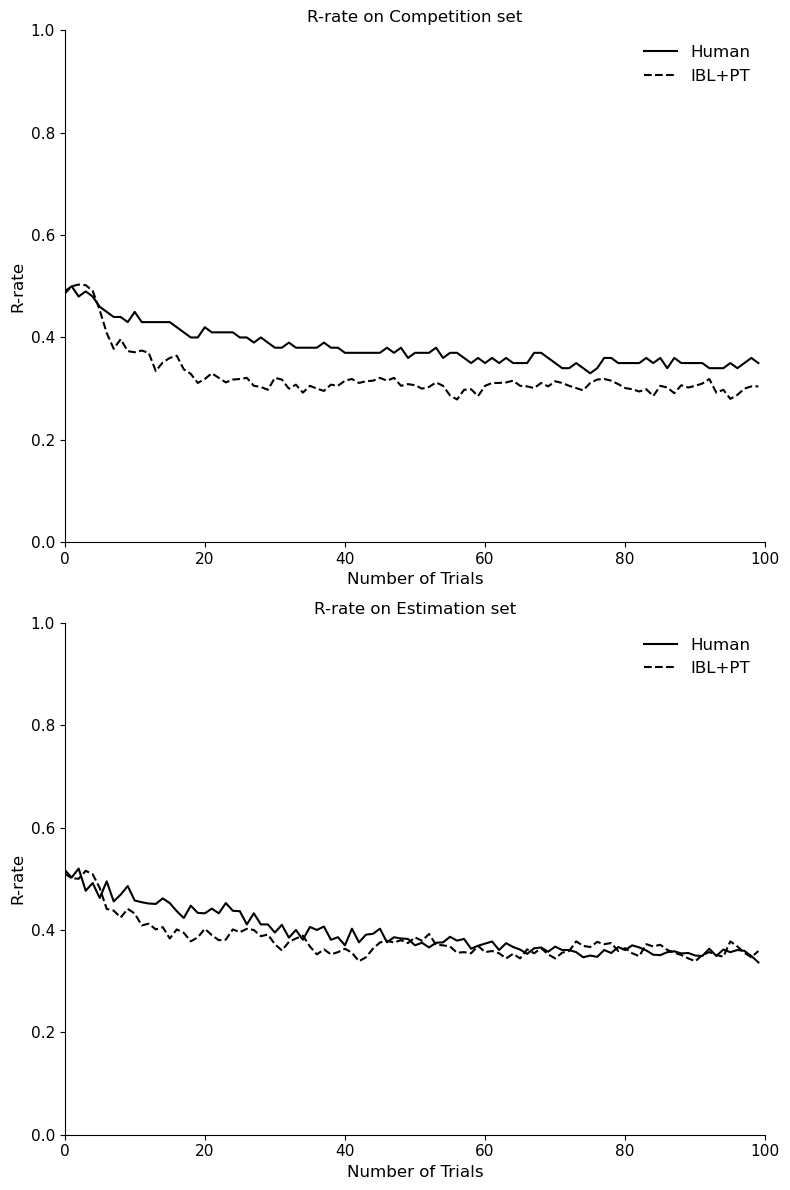

In [6]:
# Create trial range
trials = np.arange(0, 100)

# Approximate curves
human_curve = np.exp(-0.08 * (trials - 2)) * 0.9 + 0.05
ibl_curve = np.exp(-0.04 * (trials - 2)) * 0.9 + 0.15

# Plot
fig, ax = plt.subplots(2,1,figsize=(8, 12))

# Plot the lines
ax[0].plot(trials, human_r_ts_comp, color='black', linestyle='-', label='Human')
ax[0].plot(trials, r_cmp, color='black', linestyle='--', label='IBL+PT')
# ax.plot(trials, ibl_arate, color='black', linestyle=':', label='IBL')
ax[1].plot(trials, human_r_ts_est, color='black', linestyle='-', label='Human')
ax[1].plot(trials, r_est, color='black', linestyle='--', label='IBL+PT')


# Axis limits and labels
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Number of Trials', fontsize=12)
ax[0].set_ylabel('R-rate', fontsize=12)
ax[0].set_title('R-rate on Competition set')

ax[1].set_xlim(0, 100)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Number of Trials', fontsize=12)
ax[1].set_ylabel('R-rate', fontsize=12)
ax[1].set_title('R-rate on Estimation set')

# ax.set_title('equally weighted r-rate and a-rate competion set')

# Legend without frame
ax[0].legend(frameon=False, fontsize=12, loc='upper right')
ax[1].legend(frameon=False, fontsize=12, loc='upper right')

# Remove top and right spines to match the paper
sns.despine()

# Optional: Turn off grid
ax[0].grid(False)
ax[1].grid(False)


# Set ticks to appear only on the left and bottom
ax[0].yaxis.set_ticks_position('left')
ax[0].xaxis.set_ticks_position('bottom')
ax[1].yaxis.set_ticks_position('left')
ax[1].xaxis.set_ticks_position('bottom')
# Adjust tick label font size
ax[0].tick_params(axis='both', which='major', labelsize=11)
ax[1].tick_params(axis='both', which='major', labelsize=11)

plt.tight_layout()
plt.show()
